In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#set index to date column and ensure not read as normal string ie it is a date
df = pd.read_csv('monthly_milk_production.csv', index_col='Date', parse_dates=True)
#set frequency of index as monthly
df.index.frequency = 'MS'
df.head(5)

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<AxesSubplot:xlabel='Date'>

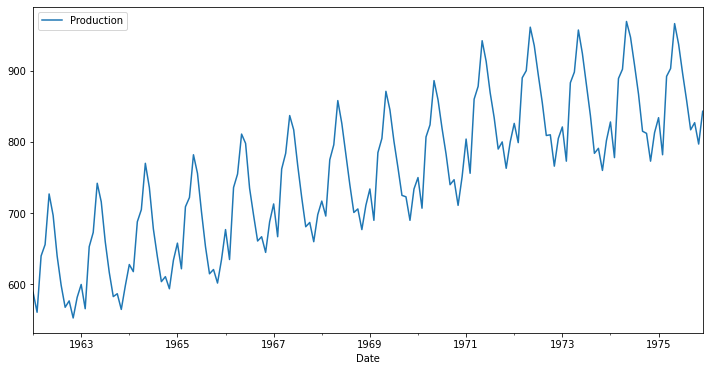

In [6]:
df.plot(figsize=(12,6))
#cyclical. 

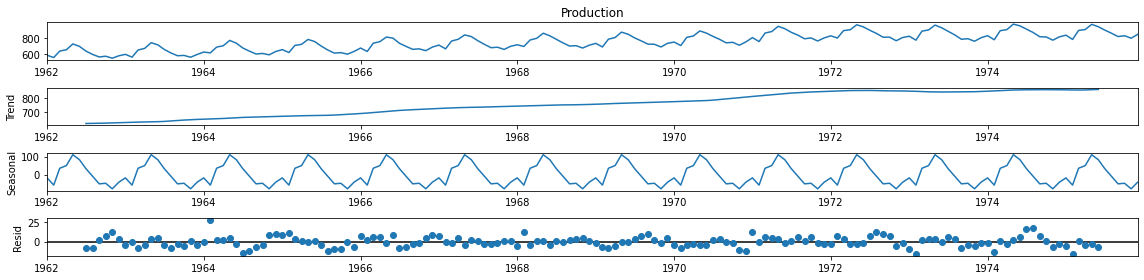

In [23]:
#check for seasonality
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(df["Production"])

rcParams["figure.figsize"] = 16, 4
decomposition.plot();

## Idea
- Could calculate noise with deep learning and use other values to get base value

## Stationary Vs. Non Stationary
### Stationary:
- A time series whose statistical properties, such as mean, variance, etc., remain constant over time.
- Statistical properties are independent of the point in time at which they are observed. 
- A stationary time series has a constant variance and it always returns to the long-run mean.

### Non-Stationary
- A time series whose statistical properties change over time and depend on point in time picked. 
- A time series with a trend or seasonality is non-stationary in nature. 
- The presence of trend or seasonality will affect the mean, variance and other properties at any given point in time. So Trend and Seasonality make a time-series non-stationary

### Impact
- Neural networks do not need stationary data but might be good to get it stationary 
- Statistical models like ARIMA and ARIMAX require stationary data. Statistical parameters constantly changing in an non-stationary time-series make it hard to predict with. So assumption is the data is stationary in most of them. 




In [28]:
### How to Get Non-Stationary Data Stationary
#If p is greater than critical value, .05 for most cases conclude the data is non-stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Production)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])


ADF Test Statistic: -1.30
5% Critical Value: -2.88
p-value: 0.63


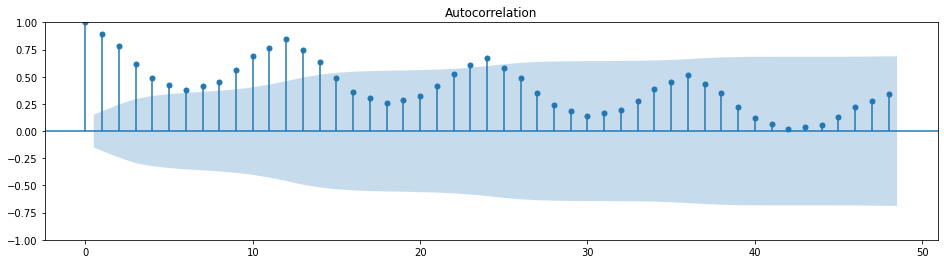

In [32]:
#auto correlation shows correlation between a time series and lagged version of itself 
#make sure no missing points and no nan values impute missing values from past
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(x=df['Production'], lags=48)
# Show the AR as a plot
plt.show()
#See a good trend every 12 months or so

In [122]:
#split test and train keep last 12 months for test
split_value = len(df)-12
train = df.iloc[:split_value]
test = df.iloc[split_value:]

In [36]:
#convert data to scale of 0 to 1 using min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [37]:
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## define generator to give data to neural network
- data and targets are basically what the network will use
- length is the … length of each sample used to train our network
- sampling_rate is the period between two outputs sub-series. In our case, with a sampling_rate of 1, each output sub-series will be spaced by one period.
- stride is the period between each record in your original data. For instance, if you have a stride of 2, it means that between your first and second record, you’ll have 2 periods, like days. It means that you’re able to space your data.
- start_index and end_index represent the range on which the different sample will be build. For instance, if your time series data has 15 records, and you fix start_index=1 and end_index=10, the 5 last records won’t be taking into the samples building.
- shuffle=True means that we want our output sub-series to be in chronological order.
- reverse=True means that our data will be in reverse chronological order
- batch_size represent the number of output sub-series per batch. In our case, only one sub-series will be output per batch.

In [87]:
#Gotta be a better way to do this, build wrapper function, where take in a dataframe and specify:
# Target column
#1. steps in past to use in series X
#2. starting step in future to use for y 
#3. ending step in future to use for y
#4. batch size is examples in a single instance
#5. if get fancy stride and sampling rate. 

from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 3 #3 months same as length
batch_size=1 #number of examples in each set to use
n_features=1 #number of features in ie number of columns in x values

#To do more steps into future need to change targets as always seems to do 1 step forward
#put in arrays for targets and data different for multivariate need to use hstack and stuff
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,  length=n_input, batch_size=batch_size)

In [88]:
generator[0]

(array([[[0.08653846],
         [0.01923077],
         [0.20913462]]]),
 array([[0.24759615]]))

In [89]:
# #Example with multi step forecasting needed
# from numpy import array
# from keras.preprocessing.sequence import TimeseriesGenerator
# # define dataset
# series = array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# target = array([[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11]])
# # define generator
# n_input = 2
# generator = TimeseriesGenerator(series, target, length=n_input, batch_size=1)
# # print each sample
# for i in range(len(generator)):
# 	x, y = generator[i]
# 	print('%s => %s' % (x, y))

In [90]:
# #multivariate example
# # multivariate one step problem
# from numpy import array
# from numpy import hstack
# from keras.preprocessing.sequence import TimeseriesGenerator
# # define dataset
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
# out_seq = array([25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
# # reshape series
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2))
# # define generator
# n_input = 1
# generator = TimeseriesGenerator(dataset, out_seq, length=n_input, batch_size=1)
# # print each sample
# for i in range(len(generator)):
# 	x, y = generator[i]
# 	print('%s => %s' % (x, y))

In [91]:
X,y = generator[0]
print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}') 

Given the array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [92]:
X.shape

(1, 3, 1)

In [93]:
#same thing for 12 months
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12 #3 months same as length
batch_size=1 #number of examples in each set to use
n_features=1 #number of features in ie number of columns in x values

#To do more steps into future need to change targets as always seems to do 1 step forward
#put in arrays for targets and data different for multivariate need to use hstack and stuff
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train,  length=n_input, batch_size=batch_size)

In [95]:
#call models
# !pip3 install Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [188]:
#Define model
model = Sequential()
model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(Dense(15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [189]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 12, 500)           1004000   
                                                                 
 dense_4 (Dense)             (None, 12, 15)            7515      
                                                                 
 dense_5 (Dense)             (None, 12, 1)             16        
                                                                 
Total params: 1,011,531
Trainable params: 1,011,531
Non-trainable params: 0
_________________________________________________________________


In [190]:
#fit model
model.fit(generator, epochs=10)

Epoch 1/10
144/144 [==============================] - 7s 40ms/step - loss: 0.0481
Epoch 2/10
144/144 [==============================] - 6s 41ms/step - loss: 0.0219
Epoch 3/10
144/144 [==============================] - 6s 42ms/step - loss: 0.0118
Epoch 4/10
144/144 [==============================] - 6s 44ms/step - loss: 0.0069: 0s -
Epoch 5/10
144/144 [==============================] - 6s 40ms/step - loss: 0.0055
Epoch 6/10
144/144 [==============================] - 6s 40ms/step - loss: 0.0034
Epoch 7/10
144/144 [==============================] - 6s 39ms/step - loss: 0.0033
Epoch 8/10
144/144 [==============================] - 6s 40ms/step - loss: 0.0029
Epoch 9/10
144/144 [==============================] - 6s 39ms/step - loss: 0.0046
Epoch 10/10
144/144 [==============================] - 6s 40ms/step - loss: 0.0028


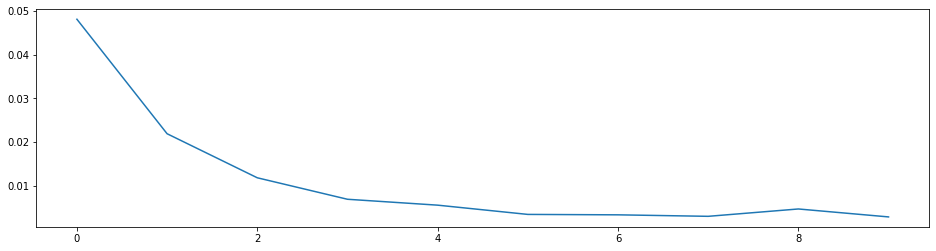

In [191]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

## With Above Know
- Probably could have stopped at 30 epoch

In [192]:
#make prediction take 12 values as input
#reformat input

#Take last 12 months in train test to make first pred on test set
last_train_batch = scaled_train[-12:]
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [193]:
#reshape it to go into model
last_train_batch = last_train_batch.reshape(1, n_input, n_features)
last_train_batch

array([[[0.66105769],
        [0.54086538],
        [0.80769231],
        [0.83894231],
        [1.        ],
        [0.94711538],
        [0.85336538],
        [0.75480769],
        [0.62980769],
        [0.62259615],
        [0.52884615],
        [0.625     ]]])

## Notes
- shape (batch_size, timesteps, feature)

In [194]:
predicted = model.predict(last_train_batch)
predicted.reshape(-1, 1)[0][0]

0.6737787

In [195]:
#unsacle it
scaler.inverse_transform(predicted.reshape(-1, 1))

array([[833.29193],
       [828.5859 ],
       [828.6365 ],
       [827.5884 ],
       [827.77734],
       [825.3754 ],
       [821.8733 ],
       [818.0731 ],
       [813.97656],
       [810.5544 ],
       [806.47   ],
       [803.32794]], dtype=float32)

In [196]:
test

,Production,pred,abs_err
Date,,,
1975-01-01,834,846.073853,0.014477
1975-02-01,782,844.655334,0.080122
1975-03-01,892,834.652710,0.064291
1975-04-01,903,844.846191,0.064401
1975-05-01,966,849.120300,0.120993
1975-06-01,937,862.754211,0.079238
1975-07-01,896,868.576904,0.030606
1975-08-01,858,870.233887,0.014259
1975-09-01,817,868.022461,0.062451


In [197]:
#Mass way to do predictions
prediction_set = df.iloc[-24:]
prediction_set

,Production
Date,
1974-01-01,828
1974-02-01,778
1974-03-01,889
1974-04-01,902
1974-05-01,969
1974-06-01,947
1974-07-01,908
1974-08-01,867
1974-09-01,815


In [198]:
scaled_values_prediction_set = scaler.transform(prediction_set)
scaled_values_prediction_set

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ],
       [0.67548077],
       [0.55048077],
       [0.81490385],
       [0.84134615],
       [0.99278846],
       [0.92307692],
       [0.82451923],
       [0.73317308],
       [0.63461538],
       [0.65865385],
       [0.58653846],
       [0.69711538]])

In [199]:
generator_preds = TimeseriesGenerator(scaled_values_prediction_set, scaled_values_prediction_set, length=n_input, batch_size=1)


In [200]:
input_scoring = generator_preds[0][0].reshape(1, n_input, n_features)
input_scoring

array([[[0.66105769],
        [0.54086538],
        [0.80769231],
        [0.83894231],
        [1.        ],
        [0.94711538],
        [0.85336538],
        [0.75480769],
        [0.62980769],
        [0.62259615],
        [0.52884615],
        [0.625     ]]])

In [201]:
predictions = [model.predict(generator_preds[i][0].reshape(1,n_input, n_features)) for i in range(0,len(generator_preds))]


In [202]:
predictions_inverse = [scaler.inverse_transform(predicted.reshape(-1, 1))[0][0] for predicted in predictions]
predictions_inverse

[833.29193,
 786.0953,
 891.5304,
 903.8405,
 968.16516,
 946.88184,
 909.5407,
 870.67084,
 820.9425,
 818.1004,
 781.4204,
 819.0475]

In [203]:
test['pred'] = predictions_inverse
test

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Production,pred,abs_err
Date,,,
1975-01-01,834,833.291931,0.014477
1975-02-01,782,786.095276,0.080122
1975-03-01,892,891.530396,0.064291
1975-04-01,903,903.840515,0.064401
1975-05-01,966,968.165161,0.120993
1975-06-01,937,946.881836,0.079238
1975-07-01,896,909.540710,0.030606
1975-08-01,858,870.670837,0.014259
1975-09-01,817,820.942505,0.062451


In [204]:
test['abs_err'] = test.apply(lambda x: abs(x['Production'] - x['pred'])/x['Production'],axis=1)
test

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Production,pred,abs_err
Date,,,
1975-01-01,834,833.291931,0.000849
1975-02-01,782,786.095276,0.005237
1975-03-01,892,891.530396,0.000526
1975-04-01,903,903.840515,0.000931
1975-05-01,966,968.165161,0.002241
1975-06-01,937,946.881836,0.010546
1975-07-01,896,909.540710,0.015112
1975-08-01,858,870.670837,0.014768
1975-09-01,817,820.942505,0.004826


In [207]:
mae = test['abs_err'].mean()
mae

0.00947993257919382

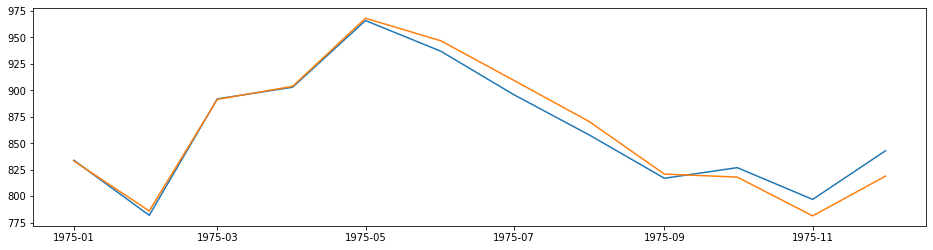

In [208]:
plt.plot(test.index, test['Production'])
plt.plot(test.index, test['pred'])